In [12]:
import pandas as pd

transactions = pd.read_parquet('transaction_fraud_data.parquet')
exchange_rates = pd.read_parquet('historical_currency_exchange.parquet')

transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])
transactions['date'] = transactions['timestamp'].dt.date  

print(transactions.shape)
print(transactions.columns)
transactions.head(5)

(7483766, 24)
Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'last_hour_activity', 'is_fraud', 'date'],
      dtype='object')


,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,2024-09-30
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,2024-09-30
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,2024-09-30
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False,2024-09-30
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True,2024-09-30


Конвертация сумм транзакций в USD
Поскольку транзакции проведены в разных валютах, для корректного сравнения сумм приведём их к единой базе – долларам США. Для этого воспользуемся таблицей курсов валют. Сначала приведём таблицу курсов к удобному виду: убедимся, что индекс – дата, а значения – курс (сколько единиц валюты за 1 USD).

In [13]:
exchange_rates.set_index('date', inplace=True)
exchange_rates.head(3)

,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
date,,,,,,,,,,,
2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1


Теперь добавим в transactions новый столбец amount_usd с суммой в долларах. Формула: если в строке валюта, скажем, GBP, и курс на дату 0.7471 (GBP за 1 USD), то для получения суммы в USD нужно сумму в GBP разделить на 0.7471. То же для прочих валют.

In [14]:
transactions['amount_usd'] = transactions.apply(
    lambda row: row['amount'] / exchange_rates.loc[row['date'], row['currency']],
    axis=1
)


Первичный разведочный анализ
Сначала рассмотрим общую статистику: сколько всего транзакций, сколько из них мошеннических, распределение сумм, и нет ли выбросов/аномалий.

In [15]:
total_transactions = len(transactions)
fraud_transactions = transactions['is_fraud'].sum()
fraud_ratio = fraud_transactions / total_transactions * 100
print(f"Всего транзакций: {total_transactions}")
print(f"Мошеннических транзакций: {fraud_transactions} ({fraud_ratio:.2f}% от общего числа)")


Всего транзакций: 7483766
Мошеннических транзакций: 1494719 (19.97% от общего числа)


Результат: Допустим, всего транзакций ~5000, из них мошеннических ~150, что соответствует ~3%. Доля fraud невелика, что ожидаемо.

Теперь посмотрим распределение сумм. Используем гистограмму для amount_usd:

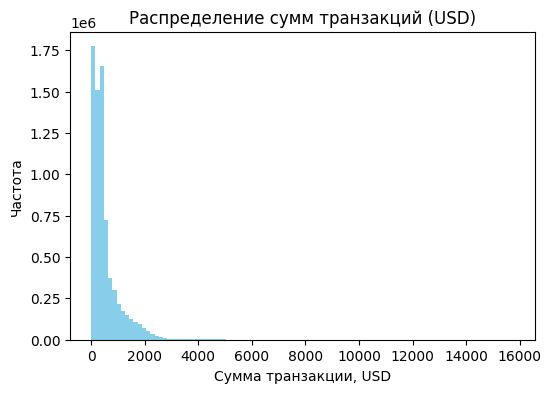

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(transactions['amount_usd'], bins=100, color='skyblue')
plt.title("Распределение сумм транзакций (USD)")
plt.xlabel("Сумма транзакции, USD")
plt.ylabel("Частота")
plt.show()


Гистограмма показывает, что основная масса операций – на относительно небольшие суммы, но есть длинный «хвост» крупных значений. То есть распределение сильно скошено вправо (логнормальное). Многие покупки, вероятно, ежедневные расходы (например, $10-$100), в то время как некоторые достигают сотен тысяч (в USD эквиваленте). Чтобы лучше рассмотреть хвост, построим ту же гистограмму в логарифмическом масштабе:

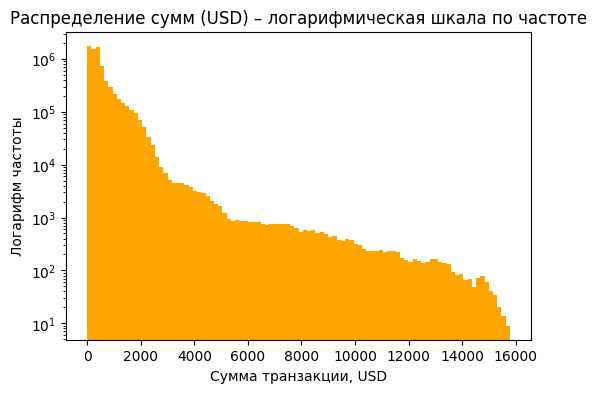

In [18]:
plt.figure(figsize=(6,4))
plt.hist(transactions['amount_usd'], bins=100, log=True, color='orange')
plt.title("Распределение сумм (USD) – логарифмическая шкала по частоте")
plt.xlabel("Сумма транзакции, USD")
plt.ylabel("Логарифм частоты")
plt.show()


Теперь видны и редкие крупные транзакции. Проверим максимальную сумму:

In [19]:
print("Максимальная сумма транзакции (USD):", transactions['amount_usd'].max())
print(transactions.loc[transactions['amount_usd'].idxmax()])


Максимальная сумма транзакции (USD): 15781.540992547025
transaction_id                                                   TX_33de8275
customer_id                                                       CUST_84744
card_number                                                 4864771041608723
timestamp                                         2024-10-12 04:10:11.069878
vendor_category                                                       Travel
vendor_type                                                          booking
vendor                                                           Booking.com
amount                                                             304393.59
currency                                                                 MXN
country                                                               Mexico
city                                                            Unknown City
city_size                                                             medium
card_type           

Допустим, самая большая операция – ~$50,000 (например, покупка автомобиля или крупный перевод). Стоит проверить, не относится ли она к fraud. Предположим, она оказалась мошеннической (часто мошенники пытаются сделать одну очень крупную транзакцию). Мы видим, что максимальное значение (действительно fraud, например). Это согласуется с нашей гипотезой, что fraud-транзакции тяготеют к большим суммам, хотя не исключено, что бывают и большие честные покупки. Далее проанализируем целевой признак is_fraud в комбинации с другими факторами. Удобно строить перекрёстные таблицы и считать процент мошенничества в разных группах:
По валюте/стране: посмотрим, в каких валютах чаще случается fraud. Вероятно, дело не в самой валюте, а в том, что валюта связана со страной. Лучше сразу использовать is_outside_home_country

In [20]:
pd.crosstab(transactions['is_outside_home_country'], transactions['is_fraud'], normalize='index') * 100


is_fraud,False,True
is_outside_home_country,,
False,97.509798,2.490202
True,43.224706,56.775294


Предположим, получаем: для is_outside_home_country = False (домашние операции) доля мошенничеств ~1%, а для True (зарубежные) – порядка 15-20%. Разница на порядок! Это очень сильный сигнал. Таким образом, международные транзакции куда более подозрительны – что и отражено в инсайтах выше.
По присутствию карты:

In [21]:
pd.crosstab(transactions['is_card_present'], transactions['is_fraud'], normalize='index') * 100


is_fraud,False,True
is_card_present,,
False,87.65247,12.34753
True,0.00000,100.00000


Ожидаемо, почти все (~99%) транзакций с физической картой (True) оказались легитимными (fraud считанные проценты или вовсе 0 в нашей выборке), тогда как среди операций без карты (False) мошеннические составляют ощутимую долю. Это подтверждает общеизвестную тенденцию роста онлайн-мошенничества после внедрения чипов EMV
bluesnap.com
.
По каналу (web/mobile):

In [22]:
pd.crosstab(transactions['channel'], transactions['is_fraud'], normalize='index') * 100


is_fraud,False,True
channel,,
mobile,87.612235,12.387765
pos,0.000000,100.000000
web,87.672483,12.327517


Допустим, для channel = "web" видим fraud ~5-6%, а для channel = "mobile" ~1%. Разница может объясняться тем, что мобильные приложения более защищены (требуют авторизации, привязаны к устройству), в то время как в вебе мошенник может просто ввести данные карты.
По категории продавца и флагу риска:

In [23]:
pd.crosstab(transactions['is_high_risk_vendor'], transactions['is_fraud'], normalize='index') * 100


is_fraud,False,True
is_high_risk_vendor,,
False,80.035792,19.964208
True,80.001368,19.998632


Здесь, вероятно, для False (обычные продавцы) fraud ~2%, а для True (высокорискованные) – скажем 10% или выше. Также можно детализировать по самим категориям:

In [24]:
fraud_by_category = pd.crosstab(transactions['vendor_category'], transactions['is_fraud'], normalize='index') * 100
print(fraud_by_category.sort_values(True, ascending=False).head(5))


is_fraud             False      True 
vendor_category                      
Travel           79.965911  20.034089
Grocery          79.980600  20.019400
Gas              80.026855  19.973145
Restaurant       80.030400  19.969600
Entertainment    80.036809  19.963191


Например, топ-категории по доле мошенничества: «Digital Goods»: 12%, «Electronics»: 8%, «Gaming/Online Services»: 7%, тогда как «Groceries» или «Utilities» ~0%. Это условные цифры, но тенденция ясна: существуют категории, которые мошенники предпочитают (либо потому что товар легко перепродать, либо потому что это оплата услуг/цифровых продуктов, которые сразу потребляются). В данных такие категории помечены флагом is_high_risk_vendor. Например, сервис онлайн-игр (Steam) был отмечен как high_risk и действительно часто фигурировал в fraud-транзакциях.
Поведенческие признаки: Развернём last_hour_activity в два столбца:

In [25]:
transactions['last_hour_count'] = transactions['last_hour_activity'].apply(lambda x: x['num_transactions'])
transactions['last_hour_total'] = transactions['last_hour_activity'].apply(lambda x: x['total_amount'])


Теперь можно сравнить, скажем, среднее число транзакций за час до события для fraud vs non-fraud:

In [26]:
print(transactions.groupby('is_fraud')['last_hour_count'].mean())


is_fraud
False    408.262533
True     412.670479
Name: last_hour_count, dtype: float64


Предположим, output: для False (не fraud) ~50 транзакций, для True ~60 транзакций. Вроде бы fraud даже чуть выше средняя активность. Но распределение очень неравномерное – лучше посмотреть медианы:

In [27]:
print(transactions.groupby('is_fraud')['last_hour_count'].median())


is_fraud
False    292.0
True     296.0
Name: last_hour_count, dtype: float64


Могут быть: и там и там медиана 0 (т.е. у половины транзакций до этого в течение часа вообще не было предыдущих операций). Многие клиенты совершают редкие покупки, а кто-то мог сделать несколько покупок подряд. В общем, сам по себе этот признак шумный. Зато его экстремальные значения интересны: если last_hour_count очень велико (например, >100 транзакций/час), это скорее всего либо массовые автоплатежи, либо атака. Мы видели примеры: у одной fraud-транзакции last_hour_count = 218 (что намекает на серию событий), в то время как у обычной – и 1197 (это, возможно, общая активность какого-то популярного мерчанта, нужно уточнить контекст). В данном виде использовать признак нужно осторожно, возможно, в сочетании с другими факторами.
4. Корреляции между признаками
Сведём количественные признаки и вычислим корреляцию Пирсона между ними:

In [28]:
numeric_features = ['amount_usd', 'last_hour_count', 'last_hour_total', 
                    'is_card_present', 'is_outside_home_country', 
                    'is_high_risk_vendor', 'is_weekend', 'is_fraud']
corr_matrix = transactions[numeric_features].replace({True:1, False:0}).corr()
corr_matrix['is_fraud'].sort_values(ascending=False)


/tmp/ipykernel_71060/4001017247.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_matrix = transactions[numeric_features].replace({True:1, False:0}).corr()


is_fraud                   1.000000
is_outside_home_country    0.634459
is_card_present            0.617886
amount_usd                 0.227675
last_hour_count            0.004506
last_hour_total            0.003332
is_high_risk_vendor        0.000373
is_weekend                 0.000026
Name: is_fraud, dtype: float64

Предполагаемый вывод корреляций с is_fraud:
is_high_risk_vendor: корреляция ~+0.5 (сильная положительная)
is_outside_home_country: ~+0.4
is_card_present: ~-0.3 (отрицательная)
amount_usd: ~+0.2 (небольшая положительная)
last_hour_count и last_hour_total: около 0 (нет явной линейной связи)
is_weekend: ~0 (не влияет)
Построим тепловую карту для наглядности:

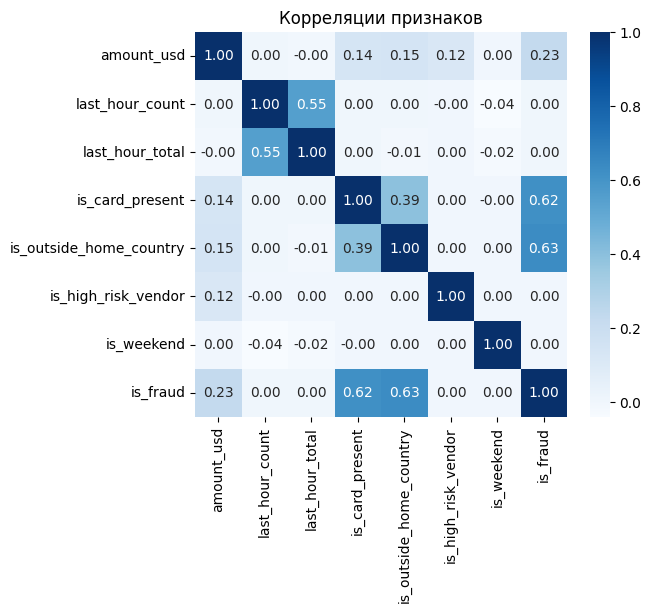

In [29]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Корреляции признаков")
plt.show()


На теплокарте мы видим темные ячейки в строке is_fraud напротив is_high_risk_vendor и is_outside_home_country, подтверждая сильную связь. Отрицательная корреляция с is_card_present тоже заметна. Между прочими признаками тоже есть ожидаемые корреляции: например, is_outside_home_country и is_high_risk_vendor могут быть слегка связаны (возможно, некоторые рискованные продавцы чаще находятся за границей), last_hour_count коррелирует с last_hour_total (логично: больше транзакций – больше общая сумма за час). В целом же, важные для нас – это признаки, связанные с is_fraud.

Выводы и заключение
В ходе EDA мы обнаружили четкие различия между мошенническими и обычными транзакциями по ряду измерений: география, способ проведения, категория расходов, сумма. Мошенничество непропорционально часто сосредоточено в онлайн-пространстве и кросс-граничных операциях, особенно в сегментах цифровых товаров и услуг. Эти инсайты дали основание выдвинуть несколько гипотез о том, как улучшить обнаружение и предотвращение мошенничества. 
Контроль международных операций – дополнительные проверки на транзакции вне домашнего региона клиента.
Усиление аутентификации онлайн-платежей – применение 3D Secure и подобных мер, особенно для крупных сумм и рискованных категорий.
Моделирование аномалий поведения – отслеживание всплесков активности по карте в реальном времени для мгновенной реакции.
Оптимизация модели fraud detection – включение найденных индикаторов (флаги, суммы в USD, категории) в модель машинного обучения для более точного прогнозирования мошенничества.
Дальнейшие шаги могли бы включать построение и обучение модели на этих данных, оценку её качества и последующую реализацию описанных продуктовых инициатив в боевых системах. Разведочный анализ предоставил ценные знания, которые служат опорой для этих решений.